In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
os.getcwd()

"/Users/sahilkhanna/Documents/Books/Fall'21/CS767/Assignment/Project"

In [3]:
print(os.path.join(os.path.expanduser('~'), "Documents/Books/Fall'21/CS767/Assignment/Project/cell_images"))

/Users/sahilkhanna/Documents/Books/Fall'21/CS767/Assignment/Project/cell_images


In [4]:
my_data_dir = os.path.join(os.path.expanduser('~'), "Documents/Books/Fall'21/CS767/Assignment/Project/cell_images")
os.listdir(my_data_dir) 
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

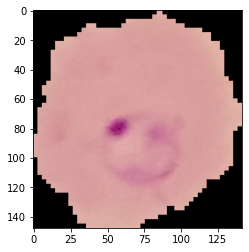

In [5]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_img= imread(para_cell)
plt.imshow(para_img)

In [6]:
para_img.shape

(148, 142, 3)

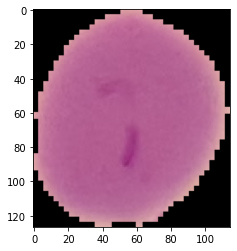

In [7]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

Let's find out the average dimensions of these images.

In [8]:
unifected_cell.shape

(127, 115, 3)

In [9]:
para_img.shape

(148, 142, 3)

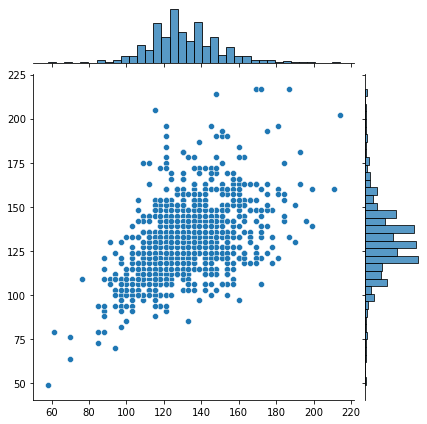

In [10]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.jointplot(dim1,dim2)

In [11]:
np.mean(dim1)

130.92538461538462

In [12]:
np.mean(dim2)

130.75

In [13]:
image_shape = (130,130,3)

## Preparing the Data for the model
There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation
Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this automatically for us. 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

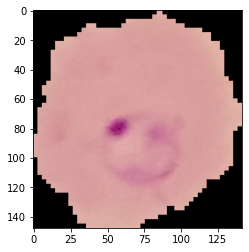

In [15]:
plt.imshow(para_img)

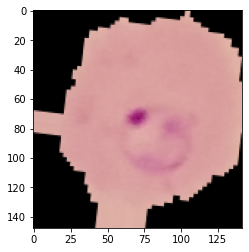

In [16]:
plt.imshow(image_gen.random_transform(para_img))

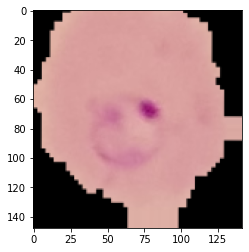

In [17]:
plt.imshow(image_gen.random_transform(para_img))

Generating many manipulated images from a directory

In [18]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [19]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Random Search Hyperparameters (Keras Tuner)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
keras.backend.clear_session()
InitSeed = 767
tf.random.set_seed(InitSeed)
np.random.seed(InitSeed)

# Time-based decay
initial_learning_rate = 0.1
epoch = 20
decay = initial_learning_rate / epoch
def lr_scheduler(epoch, learning_rate):
    return learning_rate * 1 / (1 + decay * epoch)

early_stop = EarlyStopping(monitor='val_accuracy',mode = "max", patience=7, verbose=1)

In [22]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=100,
                                               class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=100,
                                               class_mode='binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [23]:
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine import hyperparameters
import time

def hyper(hp):
    
    model = Sequential()

    model.add(Conv2D(hp.Int("input_units",32,128,32), kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    for i in range(hp.Int("n_layers",1,4)):

        model.add(Conv2D(hp.Int(f"conv_{i}_units",32,128,32), kernel_size=(3,3),input_shape=image_shape, 
                         activation='relu'))


    model.add(Flatten())


    model.add(Dense(128))
    model.add(Activation('relu'))

    # Dropouts help reduce overfitting by randomly turning neurons off during training.
    # Here we say randomly turn off 50% of neurons.
    model.add(Dropout(0.5))

    # Last layer, its binary so we use sigmoid
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model 

In [24]:
Log_dir = f"{int(time.time())}"
tuner = RandomSearch(
    hyper,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial = 1,
    directory = Log_dir)

tuner.search(x =train_image_gen, epochs=10, validation_data=(test_image_gen))

Trial 5 Complete [00h 11m 41s]
val_accuracy: 0.9338461756706238

Best val_accuracy So Far: 0.9473077058792114
Total elapsed time: 04h 27m 49s
INFO:tensorflow:Oracle triggered exit


In [25]:
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 64, 'n_layers': 3, 'conv_0_units': 96, 'conv_1_units': 32, 'conv_2_units': 32}


In [26]:
print(tuner.results_summary())

Results summary
Results in 1639192912/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 64
n_layers: 3
conv_0_units: 96
conv_1_units: 32
conv_2_units: 32
Score: 0.9473077058792114
Trial summary
Hyperparameters:
input_units: 96
n_layers: 3
conv_0_units: 64
conv_1_units: 64
conv_2_units: 64
conv_3_units: 64
Score: 0.9392307996749878
Trial summary
Hyperparameters:
input_units: 32
n_layers: 1
conv_0_units: 32
conv_1_units: 64
conv_2_units: 64
conv_3_units: 64
Score: 0.9338461756706238
Trial summary
Hyperparameters:
input_units: 96
n_layers: 1
conv_0_units: 64
conv_1_units: 128
conv_2_units: 32
conv_3_units: 96
Score: 0.61307692527771
Trial summary
Hyperparameters:
input_units: 32
n_layers: 4
conv_0_units: 32
conv_1_units: 96
conv_2_units: 64
conv_3_units: 32
Score: 0.5
None


In [27]:
print(tuner.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 96)        55392     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        27680     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 107648)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

# Create and Train the Final Model

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def metrics(test_image_gen, predictions, model):
    
    print("############################ Classification Report ############################\n\n",
          classification_report(test_image_gen.classes,predictions))
    
    plt.figure(figsize=(15,6))
    sns.heatmap(confusion_matrix(test_image_gen.classes,predictions),annot=True,cmap="Blues" ,fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix')
    plt.show()
    
    metrics_data = model.evaluate_generator(test_image_gen)
    
    print("Accuracy: {}%".format(round(metrics_data[1] * 100 ,2 )))
    print("Loss: {}\n".format(metrics_data[0]))

In [29]:
def my_design():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))

    # Dropouts help reduce overfitting by randomly turning neurons off during training.
    # Here we say randomly turn off 50% of neurons.
    model.add(Dropout(0.5))

    # Last layer, its binary so we use sigmoid
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    
    model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])
    
    return model

In [30]:
cnn = my_design()
losses = pd.DataFrame(cnn.history.history)

Epoch 1/20


2021-12-11 02:49:42.892893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7420

2021-12-11 02:50:51.194321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 74s 296ms/step - loss: 0.5042 - accuracy: 0.7420 - val_loss: 0.2310 - val_accuracy: 0.9162
Epoch 2/20
250/250 [==============================] - 74s 296ms/step - loss: 0.2214 - accuracy: 0.9250 - val_loss: 0.2087 - val_accuracy: 0.9273
Epoch 3/20
250/250 [==============================] - 73s 292ms/step - loss: 0.2097 - accuracy: 0.9311 - val_loss: 0.1822 - val_accuracy: 0.9350
Epoch 4/20
250/250 [==============================] - 75s 298ms/step - loss: 0.1890 - accuracy: 0.9398 - val_loss: 0.1691 - val_accuracy: 0.9431
Epoch 5/20
250/250 [==============================] - 74s 295ms/step - loss: 0.1774 - accuracy: 0.9431 - val_loss: 0.1713 - val_accuracy: 0.9423
Epoch 6/20
250/250 [==============================] - 73s 293ms/step - loss: 0.1665 - accuracy: 0.9483 - val_loss: 0.1610 - val_accuracy: 0.9500
Epoch 7/20
250/250 [==============================] - 75s 300ms/step - loss: 0.1568 - accuracy: 0.9504 - val_loss: 0.1683 - val_accuracy: 0.9

<AxesSubplot:title={'center':'Train vs Validation Accuracy'}, xlabel='Epochs', ylabel='Accuracy_Score'>

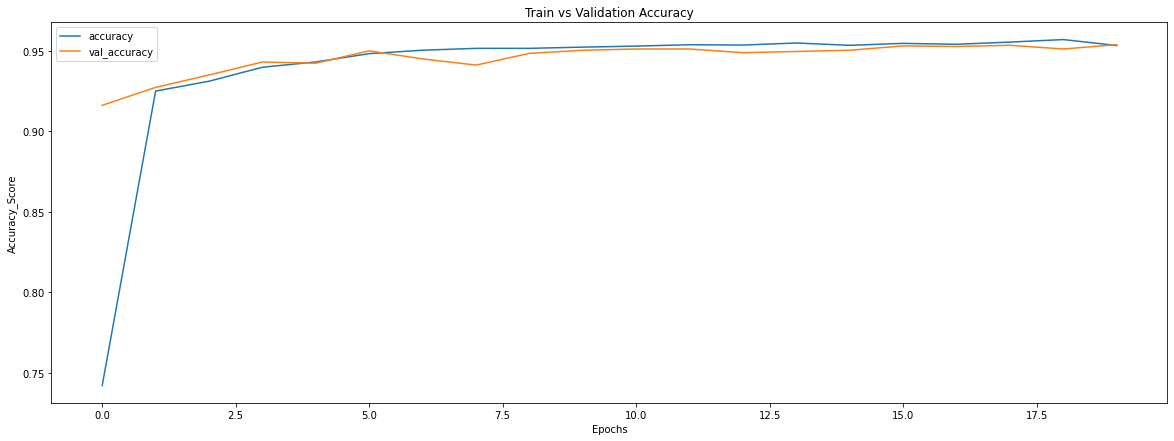

In [31]:
losses[['accuracy','val_accuracy']].plot(figsize=(20,7), 
                                     title="Train vs Validation Accuracy", 
                                     xlabel="Epochs",
                                     ylabel="Accuracy_Score")

2021-12-11 03:14:56.315894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


############################ Classification Report ############################

               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.97      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



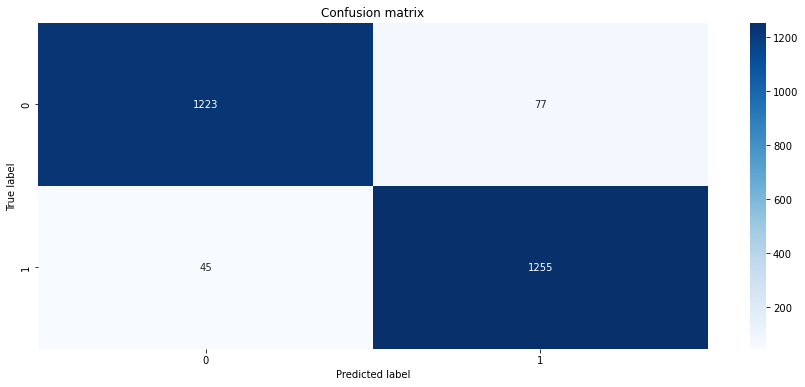

Accuracy: 95.38%
Loss: 0.13424763083457947



In [32]:
pred_probabilities = cnn.predict_generator(test_image_gen)
predictions = pred_probabilities > 0.5
metrics(test_image_gen, predictions, cnn)

In [33]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [34]:
from tensorflow.keras.models import load_model
cnn.save('malaria_detector.h5')

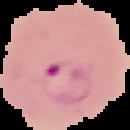

In [35]:
from tensorflow.keras.preprocessing import image
para_cell
my_image = image.load_img(para_cell,target_size=image_shape)
my_image

In [36]:
my_image = image.img_to_array(my_image)
my_image.shape

(130, 130, 3)

In [37]:
my_image = np.expand_dims(my_image, axis=0)
my_image.shape

(1, 130, 130, 3)

In [38]:
cnn.predict(my_image)

2021-12-11 03:15:08.077319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[0.]], dtype=float32)

In [39]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [40]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}